# <center>Propagation Project</center>
<hr>

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt
import matplotlib

### Figures Management

In [2]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size': 14,
    'toolbar': 'None',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'legend.fancybox': False,
    'legend.shadow': False
})

fig_path = "./figures/"

## 1. GEO to LEO

$$ P(A > A_{th}) = \sum P(A > A_{th} | \theta_i) P(\theta_i) $$

csv headers for RAPIDS data:

0. Site number	
1. Satellite number	 
2. Frequency (GHz)	 
3. Elevation angle (deg)	 
4. Elevation probability ()	 
5. Time exceeded (%)	 
6. att_comb (dB)


### 1.1 Load RAPIDS data and elevation pdf's:

In [3]:
# load RAPIDS data

class RapidsData: 
    
    
    def __init__(self, station):
        
        self.station = station
        
    
    def att_data(self, band, att_effect):
        ''' attenuation effect can be: cloud, oxygen, rain, scintillation, total, vapor. '''
        
        path_5_50  = f"./data/{band}_{self.station}_5_50/output/ascii/attenuation_{att_effect}.csv"
        path_55_90 = f"./data/{band}_{self.station}_55_90/output/ascii/attenuation_{att_effect}.csv"
        
        data_5_50  = np.genfromtxt(path_5_50, delimiter=",", skip_header=7, filling_values=0)
        data_55_90 = np.genfromtxt(path_55_90, delimiter=",", skip_header=7, filling_values=0)
        
        return np.concatenate((data_5_50, data_55_90))
    
    
    def att_idx(self, att_effect):
        ''' returns the expected indexes for each effect with the first element being the time exceeded and
            the second element being the attenuation
        '''
        
        if (att_effect == 'rain'):
            return np.array([5, 10])

        elif (att_effect == 'cloud'):
            return np.array([5, 7])
        
        elif (att_effect == 'scintillation'):
            return np.array([5, 6])
        
        else:
            return np.array([5, 6])
            
    
# load the elevation pdf's

p_theta_aus = np.array([31.322506, 20.668213, 13.976798, 9.698376, 6.394432, 5.109049, 3.178654, 2.658933,
                2.060325, 1.276102, 1.090487, 0.960557, 0.649652, 0.412993, 0.269142, 0.167053, 0.106729, 0.000000]) / 100

p_theta_nor = np.array([29.460552, 18.592851, 12.274501, 8.752253, 6.531819, 4.925548, 3.915942, 3.188046,
                2.615877, 2.244930, 2.071705, 2.143445, 1.373554, 0.894123, 0.591416, 0.318455, 0.104985, 0.000000]) / 100

# mean distances (in meters) computed with data only when el > 5deg

mean_distance_aus = 2041.5679524187844e+3
mean_distance_nor = 1966.5751836980307e+3

### 1.2 LeoSatellite Class

The purpose of this class is to compute the total attenuation function for the LEO satellite. 

In [4]:
class LeoSatellite:
    
    
    def __init__(self, location, mean_dist, band, elevation_pdf):
        
        self.location = location
        self.mean_dist = mean_dist
        self.band = band
        self.elevation_pdf = elevation_pdf 

        self.rdata = RapidsData(location)
        self.num_meas = self.meas_per_geo()
        self.num_bins = len(self.elevation_pdf)
        
        
    def interp_geo_attenuations(self, att_data, att_effect): 
        ''' returns a list of interpolation functions for each geo satellite (hence, elevation angle). '''
        
        return [interp1d(
                att_data[i * self.num_meas:(i + 1) * self.num_meas, self.rdata.att_idx(att_effect)[1]], 
                att_data[i * self.num_meas:(i + 1) * self.num_meas, self.rdata.att_idx(att_effect)[0]],
                kind='linear', bounds_error=False, fill_value=(100,0)) for i in range(self.num_bins)]
        
        
    def meas_per_geo(self): 
        ''' returns the number of measurements for each geo satellite (hence, elevation angle). '''
        
        data = self.rdata.att_data(self.band, 'total')
        
        measures = 0
        satellite_number = 1

        while(satellite_number == 1): 
                measures += 1
                satellite_number = data[measures, 1]    

        return measures
    
    
    def leo_attenuation(self, num_pts, att_effect): 
        ''' returns the attenuations along with the (in view) exceed time percentages.  '''
        
        att_data = self.rdata.att_data(self.band, att_effect)
        geo_interp = self.interp_geo_attenuations(att_data, att_effect)
        att_pts = np.linspace(0, np.max(att_data[0::self.num_meas, self.rdata.att_idx(att_effect)[1]]), num_pts)
        att_prob = np.zeros(len(att_pts))
        
        for j in range(self.num_bins):

            try:
                att_prob[:] += geo_interp[j](att_pts[:]) * self.elevation_pdf[j]

            except Exception as e:
                print(e)                    
                
        return att_pts, att_prob 
    
    
    def eirp(self, freq, T, Gr, num):
        ''' compute the eirp required for a certain outage probability. '''
        
        att_pts, att_prob = self.leo_attenuation(num, 'total')

        k = 1.381e-23 # boltzman constant
        B = 50 # Receiver bandwidth [Hz]
        lamda = 3e8 / freq # wavelength [meter]
        
        SNR = 10 # signal to noise ratio [dB]
        N = 10 * np.log10(k * T * B)  # Noise level [dBW]

        L_0 = 20 * np.log10(4 * np.pi * self.mean_dist / lamda) # free space loss [dB]
        L_atm = att_pts # Atmospheric attenuation for every probability [dB]
        L_misc = 8  # Micellaneous loss [dB]
        L = L_0 + L_atm + L_misc # total path loss
        
        eirp = SNR + N + L - Gr

        return eirp, att_prob
    
    
    def plot_geo_attenuations(self, num, att_effect, save=False):
        
        att_data = self.rdata.att_data(self.band, att_effect)
        geo_interp = self.interp_geo_attenuations(att_data, att_effect)
        att_pts = np.linspace(0, np.max(att_data[0::self.num_meas, self.rdata.att_idx(att_effect)[1]]), num=num)
        
        plt.figure()
        plt.title(f'{att_effect.capitalize()} GEO attenuations in {self.location.capitalize()}')

        for i in range(self.num_bins):

            plt.semilogx(att_data[i * self.num_meas:(i + 1) * self.num_meas, self.rdata.att_idx(att_effect)[0]],
                         att_data[i * self.num_meas:(i + 1) * self.num_meas, self.rdata.att_idx(att_effect)[1]], 
                         color="k", linewidth=.5)
            plt.semilogx(geo_interp[i](att_pts), att_pts)

        plt.xlabel('Time exceeded [\%]')
        plt.ylabel('Attenuation [dB]')
        plt.grid('on')
        
        if (save):
            plt.tight_layout()
            plt.savefig(fig_path + f"geo_{self.location}.pdf")
        else: 
            plt.show()

            
#     def plot_leo_attenuation(self, num, save=False):
        
#         att_pts = np.linspace(self.min_att, self.max_att, num=num)
#         att_prob = self.leo_total_attenuation(att_pts)                   
                
#         plt.figure()  
#         plt.title(f"Total LEO attenuation in {self.location}")
#         plt.semilogx(att_prob, att_pts, color="k")
#         plt.xlabel('Time exceeded [\%]')
#         plt.ylabel('Attenuation [dB]')
#         plt.grid('on')

#         if (save):
#             plt.tight_layout()
#             plt.savefig(fig_path + f"leo_{self.location}.pdf")
#         else: 
#             plt.show()
            
#     def plot_both(self, num, OtherLocation, legend, save=False):
        
#         att_pts = np.linspace(self.min_att, self.max_att, num=num)
#         other_att_pts = np.linspace(self.min_att, OtherLocation.max_att, num=num)
#         att_prob = self.leo_total_attenuation(att_pts)                   
                
#         plt.figure()  
#         plt.title(f"Total LEO attenuation in Norway")
#         plt.semilogx(att_prob, att_pts, color="red")
#         plt.semilogx(OtherLocation.leo_total_attenuation(other_att_pts), other_att_pts, color="blue")
#         plt.xlabel('Time exceeded [\%]')
#         plt.ylabel('Attenuation [dB]')
#         plt.legend(legend)
#         plt.grid('on')

#         if (save):
#             plt.tight_layout()
#             plt.savefig(fig_path + f"leo_{self.location}_both.pdf")
#         else: 
#             plt.show()
        

In [5]:
# Instanciation with Austria and Norway

leo_sat_aus_q = LeoSatellite('austria', mean_distance_aus, 'Q', p_theta_aus) 
leo_sat_aus_w = LeoSatellite('austria', mean_distance_aus, 'W', p_theta_aus) 
leo_sat_nor_q = LeoSatellite('norway', mean_distance_nor, 'Q', p_theta_nor) 
leo_sat_nor_w = LeoSatellite('norway', mean_distance_nor, 'W', p_theta_nor) 

## 2. Plots

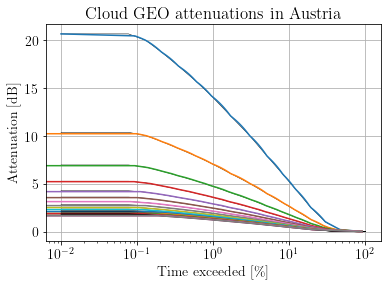

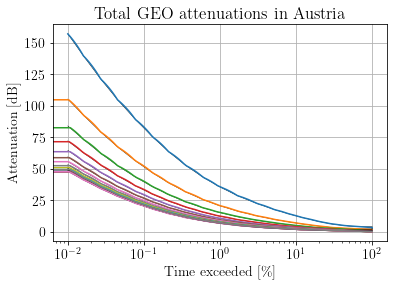

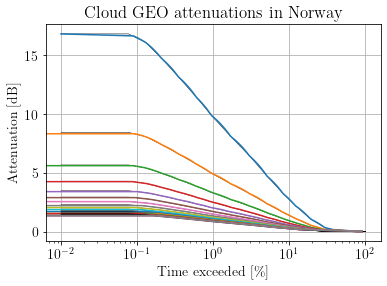

In [6]:
leo_sat_aus_q.plot_geo_attenuations(100, 'cloud', save=False)
leo_sat_aus_q.plot_geo_attenuations(100, 'total', save=False)
leo_sat_nor_q.plot_geo_attenuations(100, 'cloud', save=False)

## 3. Link Budget

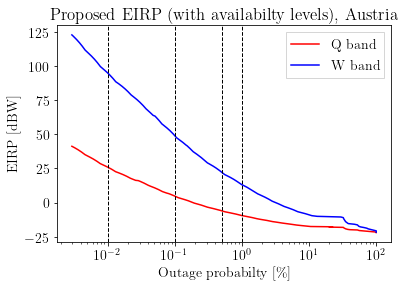

In [7]:
num=300

eirp_aus_37 = leo_sat_aus_q.eirp(37.5e9, 450, 44.76, num) # Frequency, temperature, Antenna Gain
eirp_nor_37 = leo_sat_nor_q.eirp(37.5e9, 450, 44.76, num)

eirp_aus_75 = leo_sat_aus_w.eirp(75.5e9, 500, 51, num)
eirp_nor_75 = leo_sat_nor_w.eirp(75.5e9, 500, 51, num)

plt.figure()
plt.title('Proposed EIRP (with availabilty levels), Austria')

# plt.semilogx(eirp_aus_37[0], eirp_aus_37[1], color='red', label="Q band")
# plt.semilogx(eirp_aus_75[0], eirp_aus_75[1], color='blue', label="W band")

plt.semilogx(eirp_nor_37[1], eirp_nor_37[0], color='red', label="Q band")
plt.semilogx(eirp_nor_75[1], eirp_nor_75[0], color='blue', label="W band")

plt.axvline(1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.5, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.1, color='k', linestyle='dashed', linewidth=1)
plt.axvline(0.01, color='k', linestyle='dashed', linewidth=1)

plt.xlabel('Outage probabilty [\%]')
plt.ylabel('EIRP [dBW]')
plt.legend()

if (0):
    plt.tight_layout()
    plt.savefig(fig_path + f"eirp_aus.pdf")
else: 
    plt.show()
    

# Link Budget for Norway
